[View in Colaboratory](https://colab.research.google.com/github/JozeeLin/google-tensorflow-exercise/blob/master/validation.ipynb)

## 验证
学习目标:
- 使用多个特征而非单个特征来进一步提高模型的有效性
- 调试模型输入数据中的问题
- 使用测试数据集检查模型是否过拟合验证数据


## 设置
首先，加载并准备数据。这一次，我们将使用多个特征，因此将逻辑模块化，以对特征进行预处理：

In [0]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset #这是什么东西?

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=',')

In [0]:
def preprocess_features(california_housing_dataframe):
  selected_features = california_housing_dataframe[
      [
          'latitude',
          'longitude',
          'housing_median_age',
          'total_rooms',
          'total_bedrooms',
          'population',
          'households',
          'median_income'
      ]
  ]
  processed_features = selected_features.copy()
  #create a synthetic feature
  processed_features['rooms_per_person'] = (
      california_housing_dataframe['total_rooms'] /
      california_housing_dataframe['population']
  )
  return processed_features

In [0]:
def preprocess_targets(california_housing_dataframe):
  output_targets = pd.DataFrame()
  #scale the target to be in units of thousands of dollars
  output_targets['median_house_value'] = (
    california_housing_dataframe['median_house_value']/1000.0
  )
  return output_targets

对于训练集，从共17000个样本中选择前12000个样本

In [7]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,34.6,-118.5,27.5,2655.7,547.1,1476.0,505.4,3.8,1.9
std,1.6,1.2,12.1,2258.1,434.3,1174.3,391.7,1.9,1.3
min,32.5,-121.4,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.8,-118.9,17.0,1451.8,299.0,815.0,283.0,2.5,1.4
50%,34.0,-118.2,28.0,2113.5,438.0,1207.0,411.0,3.5,1.9
75%,34.4,-117.8,36.0,3146.0,653.0,1777.0,606.0,4.6,2.3
max,41.8,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


In [8]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,198.0
std,111.9
min,15.0
25%,117.1
50%,170.5
75%,244.4
max,500.0


对于验证集，从17000个样本中选择后5000个样本

In [9]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,38.1,-122.2,31.3,2614.8,521.1,1318.1,491.2,4.1,2.1
std,0.9,0.5,13.4,1979.6,388.5,1073.7,366.5,2.0,0.6
min,36.1,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,37.5,-122.4,20.0,1481.0,292.0,731.0,278.0,2.7,1.7
50%,37.8,-122.1,31.0,2164.0,424.0,1074.0,403.0,3.7,2.1
75%,38.4,-121.9,42.0,3161.2,635.0,1590.2,603.0,5.1,2.4
max,42.0,-121.4,52.0,32627.0,6445.0,28566.0,6082.0,15.0,18.3


In [10]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,229.5
std,122.5
min,15.0
25%,130.4
50%,213.0
75%,303.2
max,500.0


## 任务1：检查数据
- 对于一些值，我们可以检查这些值是否位于合理的范围内
- 对于latitude和longitude等其他值，我们通过google进行快速搜索，并快速检查一下它们的预期值是否一致。
可发现下列异常情况:
- median_income位于3到15的范围内。而但不知道此范围究竟指的是什么，对数尺度?无法找到相关记录；值越高，相应的收入越高。
- median_house_value的最大值是500001.看起来像某种人为设定的上限。
- rooms_per_person特征通常在正常范围内，其中第75百分位数的值约为2.但也有一些非常大的值(例如18或55)，这可能表明数据有一定程度的损坏

In [13]:
print(california_housing_dataframe['median_income'].max(),california_housing_dataframe['median_income'].min())

15.0001 0.4999


## 任务2：绘制维度/经度与房屋价值中位数的曲线图
利用这两个特征可以提供出色的可视化结果-我们来绘制latitude和longitude的曲线图，然后用颜色标注median_house_value

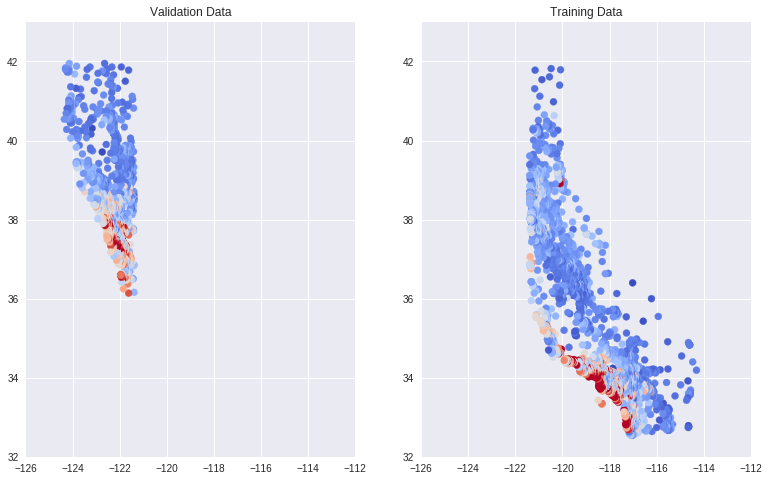

In [17]:
plt.figure(figsize=(13,8))
ax = plt.subplot(1,2,1)
ax.set_title('Validation Data')

ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])
plt.scatter(validation_examples['longitude'],
           validation_examples['latitude'],
           cmap='coolwarm',
           c=validation_targets['median_house_value']/validation_targets['median_house_value'].max())

ax = plt.subplot(1,2,2)
ax.set_title('Training Data')

ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])
plt.scatter(training_examples['longitude'],
           training_examples['latitude'],
           cmap='coolwarm',
           c=training_targets['median_house_value']/training_targets['median_house_value'].max())

_ = plt.plot()

现在应该呈现出一幅不错的加利福尼亚州地图了。其中旧金山和洛杉矶等住房成本高昂的地区用红色表示
<br>
通过观察发现上面两张图的分布并不相似
<br>
你能看出训练数据和验证数据之间的特征或目标分布有任何其他差异吗?
<br>
**注意:关键一点在于，对于任何指定特征或列，训练集和验证集之间的值得分布应该大致相同。**
<br>
**通过上面的两张图表明我们创建训练集和验证集的拆分方式很可能存在问题**

## 任务3：返回来看数据导入和预处理代码，看一下您是否发现了任何错误
**注意：机器学习中的调试通常是数据调试而不是代码调试。如果数据有误，即使最高级的机器学习代码也挽救不了局面**
<br>
对于前面的数据划分问题的解决思路是:先把全部的数据集进行随机化处理，然后在进行训练集和验证集划分。

In [0]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [0]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

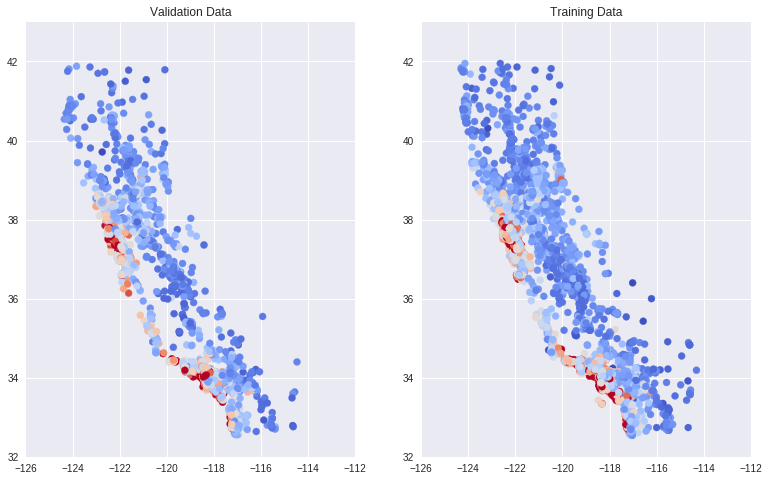

In [20]:
plt.figure(figsize=(13,8))
ax = plt.subplot(1,2,1)
ax.set_title('Validation Data')

ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])
plt.scatter(validation_examples['longitude'],
           validation_examples['latitude'],
           cmap='coolwarm',
           c=validation_targets['median_house_value']/validation_targets['median_house_value'].max())

ax = plt.subplot(1,2,2)
ax.set_title('Training Data')

ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])
plt.scatter(training_examples['longitude'],
           training_examples['latitude'],
           cmap='coolwarm',
           c=training_targets['median_house_value']/training_targets['median_house_value'].max())

_ = plt.plot()

## 任务4:训练和评估模型
首先，尝试不同的超参数设置，尽可能获取最佳验证效果
<br>
然后，使用数据集中的所有特征训练一个线性回归器，看看其表现如何
<br>
定义输入函数

In [0]:
def my_input_fn(feature, targets, batch_size=1, shuffle=True, num_epochs=None):
  #将pandas特征数据转换成NumPy数组字典
  features = {key:np.array(value) for key,value in dict(feature).items()}
  #将数据拆分成大小为batch_size的多批数据，以按照指定周期数(num_epochs)进行重复
  ds = Dataset.from_tensor_slices((features, targets)) #warning: 2GB limit
  ds = ds.batch(batch_size).repeat(num_epochs)
  #是否对数据进行随机处理，buffer_size为随机抽样的数据集大小
  if shuffle:
    ds = ds.shuffle(buffer_size=10000)
    
  #为数据集构建一个迭代器
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

In [0]:
#由于使用多个输入特征，因此需要把用于将特征列配置为独立函数的代码模块化。(目前代码相当简单，因为我们的所有特征都是数值，但当我们在今后的练习中使用其他类型的特征时，会基于此代码进行构建)
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

使用我们之前了解的一些方法检查数据。这些方法可能包括:
- 比较预测值和实际目标值的分布情况
- 绘制预测值和目标值的散点图
- 使用latitude和longitude绘制两个验证数据散点图:
  - 一个散点图将颜色映射到实际目标median_house_value
  - 另一个散点图将颜色映射到预测的median_house_value,并排进行比较

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets
):
  periods = 10
  steps_per_period = steps/periods
  #create a linear regressor object
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns = construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  #1. Create input functions
  training_input_fn = lambda: my_input_fn(
      training_examples,
      training_targets['median_house_value'],
      batch_size=batch_size
  )
  
  predict_training_input_fn = lambda: my_input_fn(
      training_examples,
      training_targets['median_house_value'],
      num_epochs=1,
      shuffle=False
  )
  
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets['median_house_value'],
      num_epochs=1,
      shuffle=False
  )
  
  #Train the model,but do so inside a loop so that we can periodically assess
  #loss metrics
  print("Training model...")
  print("RMSE(on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range(0, periods):
    #train the model, starting from the prior state
    linear_regressor.train(
        input_fn = training_input_fn,
        steps = steps_per_period,
    )
    #take a break and compute predictions
    training_predictions = linear_regressor.predict(input_fn = predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn = predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    #Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets)
    )
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets)
    )
    #Occasionally print the current loss
    print("period %02d : %0.2f" % (period, training_root_mean_squared_error))
    #add the loss metrics from this period to our list
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
    
  print("Model training finished")
  #output a graph of loss metrics over periods
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title('Root Mean Squared Error vs Periods')
  plt.tight_layout()
  plt.plot(training_rmse, label='training')
  plt.plot(validation_rmse, label='validation')
  plt.legend()
  
  return linear_regressor

Training model...
RMSE(on training data):
period 00 : 217.94
period 01 : 200.29
period 02 : 186.64
period 03 : 176.54
period 04 : 170.59
period 05 : 167.52
period 06 : 166.78
period 07 : 167.09
period 08 : 168.07
period 09 : 169.58
Model training finished


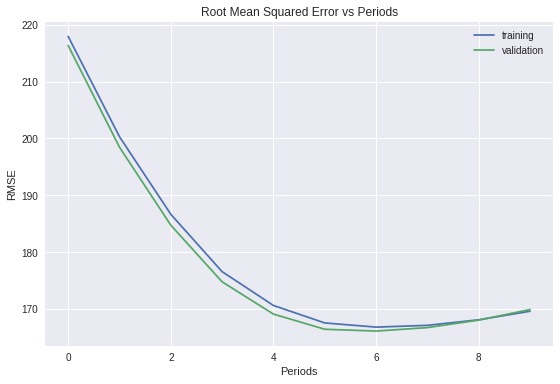

In [24]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets
)

## 任务5：基于测试数据进行评估

In [0]:
california_housing_test_data = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_test.csv", sep=",")

In [28]:
test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 162.85
